<a href="https://colab.research.google.com/github/TheBlackRus/liveproject_HumanPoseEstimation/blob/master/liveproject_humanpose_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torchvision
import torch

In [2]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']#, 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping val2017.zip
Done transferring all datasets


In [0]:
# read the meta data of the validation set
import json
file_name = "annotations//person_keypoints_val2017.json"
with open(file_name, 'r') as json_raw:
    meta = json.load(json_raw)

In [0]:
example = 0
img_info = meta["images"][example]
img_annotation = meta["annotations"][example]
img_catogory = meta["categories"][0]["keypoints"]

In [5]:
img_file = str(img_annotation["image_id"])
img_file = img_file.zfill(12) +".jpg" #img_info["file_name"]
print(img_file, img_annotation["image_id"])

000000425226.jpg 425226


In [0]:
def resize_image(img, target_width=192, target_height=256):
  img_resized = cv2.resize(img,(target_width,target_height))
  return img_resized

def crop_image(img, upper_left_corner, size):
  start_x, start_y = upper_left_corner
  w,h = size
  img_cropped = img[int(start_y):(int(start_y+h)),int(start_x):int(start_x+w),:]
  return img_cropped

def adjust_keypoint(keypoint, start, scale):
  keypoint_x, keypoint_y= keypoint
  start_x,start_y = start
  sx,sy = scale
  x = (keypoint_x-start_x)*sx
  y = (keypoint_y-start_y)*sy
  return x,y


In [0]:
%matplotlib inline
#from matplotlib.pyplot import imshow
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [0]:
img = image.imread("val2017//"+img_file)
img = img / 255.0

In [9]:
img_batch = torch.Tensor([img, img])
print(img_batch.shape)
img_batch = img_batch.permute([0,3,2,1])
img_batch.shape

torch.Size([2, 640, 480, 3])


torch.Size([2, 3, 480, 640])

In [0]:
img_batch.max()
img_batch = img_batch.cuda()

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.cuda()
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [12]:
y = model(img_batch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [0]:
import numpy as np


In [14]:
y

[{'boxes': tensor([[212.5397,  64.2023, 563.9282, 358.7718],
          [355.1589, 226.9010, 394.5103, 299.8187],
          [389.6106,  89.7069, 565.4318, 280.4237],
          [ 31.8342, 141.2250, 331.9860, 406.0846],
          [505.8641, 118.0132, 577.4388, 238.9388],
          [ 48.9421,  52.3993, 567.9709, 441.1093],
          [269.1020, 288.9832, 305.5331, 314.1668],
          [236.7639, 178.1634, 305.9442, 259.8866],
          [227.3062, 120.0427, 242.7734, 138.9593],
          [338.5215, 220.8336, 377.9923, 313.5775],
          [187.0308,  13.4958, 254.0475,  83.2915],
          [197.4344, 300.9328, 606.9046, 453.8034],
          [365.9975, 226.3490, 393.0796, 276.2736],
          [339.6570, 226.1735, 356.4973, 312.2776],
          [296.6670, 292.5830, 333.8354, 310.4262],
          [ 48.6918, 261.7969, 128.5480, 354.0468],
          [ 64.2550,  53.7829, 594.8115, 415.7347],
          [284.8064, 285.2485, 445.4221, 315.1196],
          [232.7171, 141.9245, 239.5738, 164.5803],
   

tensor([[212.5397,  64.2023, 563.9282, 358.7718],
        [313.9790, 241.6604, 344.0585, 303.8826],
        [ 78.5636, 211.0039, 108.7784, 248.1253],
        [231.8022, 103.0909, 458.8400, 315.9155]], device='cuda:0',
       grad_fn=<IndexBackward>) tensor([0.8693, 0.0817, 0.0767, 0.0649], device='cuda:0',
       grad_fn=<IndexBackward>)


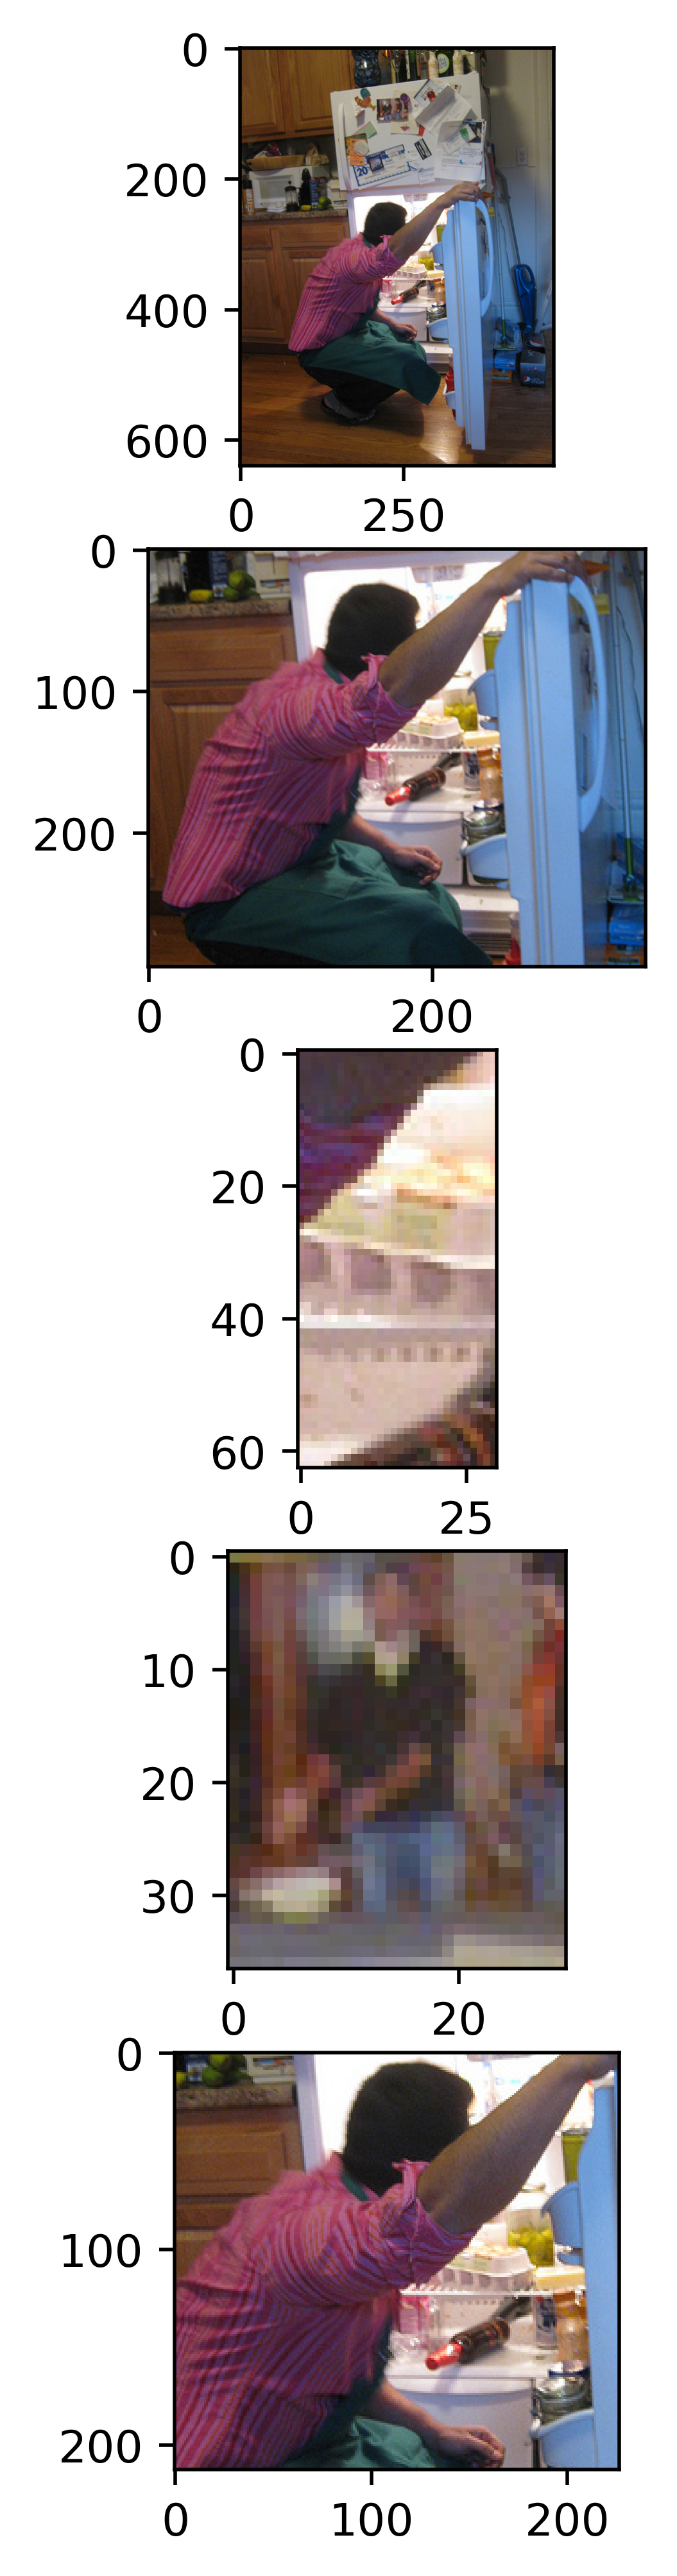

In [15]:
y[0]["labels"] = y[0]["labels"].to("cpu")
#y[0]["scores"] = y[0]["labels"].to("cpu")
ex = y[0]["boxes"][np.where(y[0]["labels"]==1)]
sc = y[0]["scores"][np.where(y[0]["labels"]==1)]
print(ex,sc)
fig,ax = plt.subplots(len(ex)+1,figsize=(20,10))
ax[0].imshow(img)
fig.set_dpi(500)
i= 1
for box in ex:

  crop_img = crop_image(img,(box[1],box[0]),(box[2]-box[0],box[3]-box[1]))
  ax[i].imshow(crop_img)
  i +=1  
plt.show()

In [0]:
class Detector:
  GPU = "cuda"
  CPU = "cpu"
  PERSON_CATEGORY = 1

  def __init__(self,device= GPU):
    self.device = device
    self.model = self.load_model()
    
  def load_model(self):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    if self.device == self.GPU:
      model.cuda()
    return model

  def find_person(self,img,preproces=True,
                  category=PERSON_CATEGORY,
                  resize = (192,256),
                  treshold = 0.5,
                  vis=False):
    
    return self.find_object(img,preproces,category,
                            resize=resize,
                            treshold=treshold,
                            vis=vis)

  def find_object(self,img,preproces,category,resize = (192,256),treshold = 0.5, vis=False):
    if preproces:
      img = self.preproces_image(img)

    img_batch = self.single_image_to_batch(img)

    y = self.model(img_batch)

    boxes, scores = self.__get_boxes(y,category,treshold)

    if vis:
      self.vis_boxes(img,boxes)

    res_images = []
    for box in boxes:
      crop_img = self.crop_box(img,box)
      if resize is not None:
        crop_img = self.resize_image(crop_img,resize)
      res_images.append(crop_img)

    return boxes, scores, res_images  

  def vis_boxes(self,img,boxes):
    print("vis",len(boxes))
    fig,ax = plt.subplots(len(boxes)+1,figsize=(20,10))
    if len(boxes):
      ax[0].imshow(img)
      fig.set_dpi(500)
      i= 1
      
      for box in boxes:
        crop_img = self.crop_box(img,box)
        ax[i].imshow(crop_img)
        i +=1
    else:
      ax.imshow(img)
      fig.set_dpi(500)
    plt.show()

  def __get_boxes(self,y,category,treshold):
    if self.device == self.GPU:
      y[0]["labels"] = y[0]["labels"].to("cpu")
      y[0]["scores"] = y[0]["scores"].to("cpu")

    boxes = y[0]["boxes"][np.where(y[0]["labels"]==category)]
    scores = y[0]["scores"][np.where(y[0]["labels"]==category)]
    boxes = boxes[np.where(scores>=treshold)]
    scores = scores[np.where(scores>=treshold)]
    print(boxes, scores)

    return boxes, scores

  def crop_box(self,img,box):
    upper_left_corner = (box[1],box[0])
    size = (box[2]-box[0],box[3]-box[1])

    return self.crop_image(img,upper_left_corner,size)

  def crop_image(self,img, upper_left_corner, size):
    start_x, start_y = upper_left_corner
    w,h = size
    img_cropped = img[int(start_y):(int(start_y+h)),int(start_x):int(start_x+w),:]
    return img_cropped

  def resize_image(self,img, resize =(192,256)):
    target_width, target_height = resize
    img_resized = cv2.resize(img,(target_width,target_height))
    return img_resized

  def preproces_image(self,img):
    img = img / 255.0
    return img

  def single_image_to_batch(self,img):
    img_batch = torch.Tensor([img, img])

    print(img_batch.shape)
    img_batch = img_batch.permute([0,3,2,1])
    print(img_batch.shape)
    if self.device == self.GPU:
      img_batch = img_batch.cuda()
    return img_batch






In [0]:
dec = Detector()

In [0]:
import json
file_name = "annotations//person_keypoints_val2017.json"
with open(file_name, 'r') as json_raw:
    meta = json.load(json_raw)

def load_image(meta,example):
  # read the meta data of the validation set
  img_info = meta["images"][example]
  img_annotation = meta["annotations"][example]
  img_catogory = meta["categories"][0]["keypoints"]

  img_file = str(img_annotation["image_id"])
  img_file = img_file.zfill(12) +".jpg" #img_info["file_name"]
  print(img_file, img_annotation["image_id"])
  return image.imread("val2017//"+img_file)

In [19]:
img_1 = load_image(meta,1)

000000440475.jpg 440475


In [20]:
img_X = load_image(meta,7)
boxes, scores, res_imgs =dec.find_person(img_X,preproces=True,treshold=0.3,vis=False)

000000291634.jpg 291634
torch.Size([2, 640, 433, 3])
torch.Size([2, 3, 433, 640])
tensor([[186.7509, 281.1734, 285.5057, 406.2098],
        [196.3102,   1.0712, 255.0572,  39.5281],
        [184.4072, 316.5486, 240.3932, 379.2916],
        [202.6456, 345.7126, 268.9996, 376.9846]], device='cuda:0',
       grad_fn=<IndexBackward>) tensor([0.8949, 0.6144, 0.5566, 0.3301], grad_fn=<IndexBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [21]:
scores = scores.to("cpu")
scores[np.where(scores>=0.5)]

tensor([0.8949, 0.6144, 0.5566], grad_fn=<IndexBackward>)

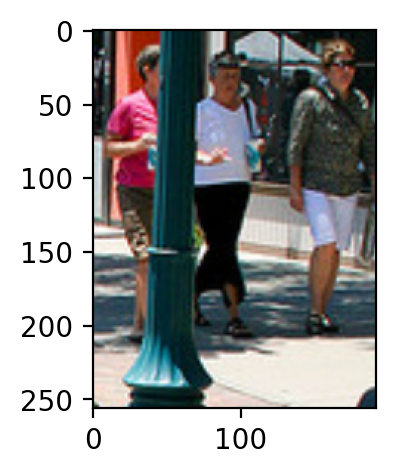

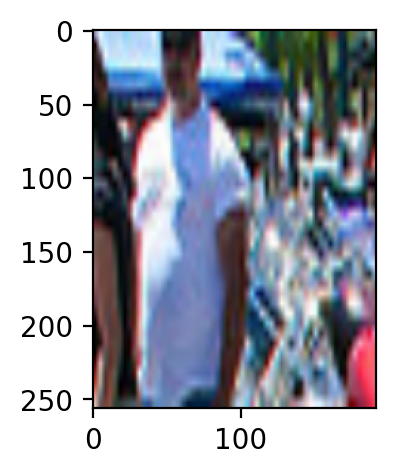

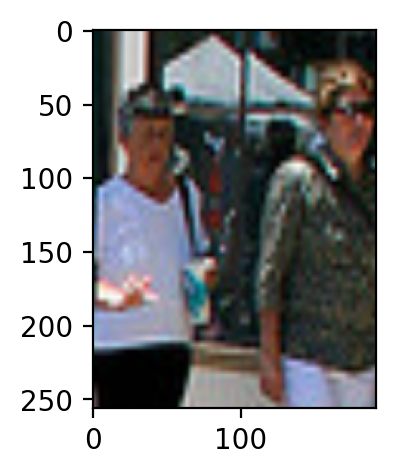

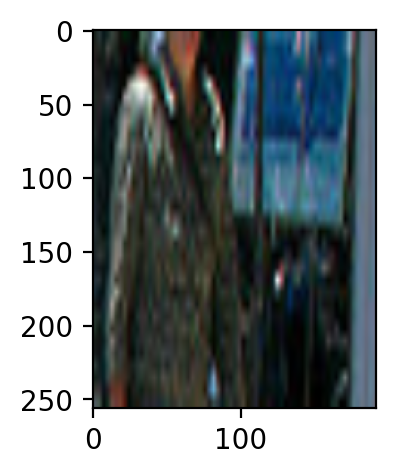

In [22]:
 for prev in res_imgs:
   fig,ax = plt.subplots(1,figsize=(5,2.5))
   fig.set_dpi(200)
   ax.imshow(prev)
   plt.show()
 


In [23]:
"""
# For training
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)
output = model(images, targets)
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

# optionally, if you want to export the model to ONNX:
torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)
"""

'\n# For training\nimages, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)\nlabels = torch.randint(1, 91, (4, 11))\nimages = list(image for image in images)\ntargets = []\nfor i in range(len(images)):\n    d = {}\n    d[\'boxes\'] = boxes[i]\n    d[\'labels\'] = labels[i]\n    targets.append(d)\noutput = model(images, targets)\n# For inference\nmodel.eval()\nx = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]\npredictions = model(x)\n\n# optionally, if you want to export the model to ONNX:\ntorch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)\n'